# Notebook for Generating Summaries

In [1]:
import os
num_threads = 32
os.environ['NUMEXPR_MAX_THREADS'] = str(num_threads)
os.environ["TF_FORCE_GPU_ALLOW_GROWTH"]="true"

import warnings
warnings.simplefilter(action='ignore', category=DeprecationWarning)  # rid tqdm depreciation warning

import pandas as pd
import numpy as np
import pickle
import copy
import math
from collections import defaultdict
# from tqdm import tqdm
from tqdm import tqdm_notebook
from sentence_transformers import SentenceTransformer
import ipynb.fs

from sklearn.neighbors import KDTree

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import InputLayer
from tensorflow.keras.layers import GRU
from tensorflow.keras.layers import LSTM

import kerastuner as kt
from kerastuner.engine.hyperparameters import HyperParameters
from kerastuner.tuners import Hyperband

import spacy

from multiprocessing import Pool

In [2]:
gpus = tf.config.list_physical_devices('GPU')
print("gpus:")
print(gpus)
# for gpu in gpus:
#     tf.config.experimental.set_memory_growth(gpu, True)  # should stop error with LSTMs

gpus:
[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU'), PhysicalDevice(name='/physical_device:GPU:1', device_type='GPU'), PhysicalDevice(name='/physical_device:GPU:2', device_type='GPU'), PhysicalDevice(name='/physical_device:GPU:3', device_type='GPU')]


## Keras NN Model

In [3]:
class NNTuner:
    def __init__(self, save_dir, save_name, input_shape, tuning_iterations=2, max_epochs=15, reduction_factor=3,
                 batch_size=32, force_reload=False, output_dims=1, layer_type="LSTM"):
        """Can save using project_name param, if overwrite false then will reload where it started
        In Tuner Class documentation
        """
        self.input_shape = input_shape
        self.output_dims = output_dims
        self.batch_size = batch_size
        self.layer_type = layer_type.upper()
        self.models = []
        self.distribution_strategy=tf.distribute.MirroredStrategy(cross_device_ops=tf.distribute.HierarchicalCopyAllReduce())

        self.tuner = Hyperband(self.build_model, 
                          objective='mean_squared_error', 
                          max_epochs=max_epochs,
                          hyperband_iterations=tuning_iterations,
                          factor=reduction_factor,  # keras-tuner default is 3
                          directory=save_dir,
                          project_name=save_name,
                          overwrite=force_reload,
                          tune_new_entries = True,
                          allow_new_entries = True,
                          distribution_strategy=self.distribution_strategy)

        
    def build_model(self, hp):
        model = Sequential()
        # specify input layer to ensure correct input shape
        
        ilayer = None
        if self.layer_type == "LSTM":
            batch_shape = list(self.input_shape)
            batch_shape.insert(0, self.batch_size)
            batch_shape = tuple(batch_shape)
            print("batch_shape : " + str(batch_shape))
            ilayer = tf.keras.Input(batch_shape=batch_shape,
                                name='input_layer')
        elif self.layer_type == "DENSE":
            ilayer = tf.keras.Input(shape=self.input_shape[-1], batch_size=self.batch_size)
        model.add(ilayer)
        
        # add hidden layers
        num_hidden_layers = hp.Int('num_hidden_layers', min_value=1, max_value=6)
        for i in range(num_hidden_layers):
            
            units_name = 'hidden_units_' + str(i)
            units = hp.Int(units_name, min_value=32, max_value=2048, step=32)
            print(units_name + ": " + str(units))
            name = 'hidden_layer_' + str(i)
            
            if self.layer_type == "DENSE":
                model.add(Dense(units=units,
                                activation='tanh',
                                name=name))
                
            elif self.layer_type == "LSTM":
                return_sequences = True
                if i == num_hidden_layers - 1:
                    return_sequences = False  # don't return sequences to Dense layer
                    
                model.add(LSTM(units=units,
                              activation='tanh',
                              recurrent_activation='sigmoid',
                              unroll=False,
                              use_bias=True,
                              return_sequences=return_sequences,
                              batch_size=self.batch_size,
                              stateful=False,
                              name=name))
            else:
                raise Exception(str(self.layer_type) + " is not a valid layer type")
            
        # add output layer
        model.add(Dense(units=self.output_dims, 
                        activation='tanh'))
        
        opt = tf.keras.optimizers.Adam(
                learning_rate=hp.Float('learning_rate', min_value=0.000001, max_value=0.001))      
        
        model.compile(optimizer=opt, loss='huber', metrics=['mean_squared_error'])  # add metrics here
        
        self.models.append(model)
        return model
    
    def search(self, batch_generator, best_model_dir):
        """Find optimal model given dataset
        """
        self.tuner.search(x=batch_generator, verbose=1, use_multiprocessing=False, workers=num_threads)
        best_models = self.tuner.get_best_models(num_models=5)
        if best_model_dir is not None:
            for i in range(len(best_models)):
                print("Saving best model number: " + str(i))
                save_path = os.path.join(best_model_dir, str(i))
                best_models[i].save(save_path)
            hyperparams = self.tuner.get_best_hyperparameters(num_trials=1)[0]
        best_model_path = os.path.join(best_model_dir, str(0))
        return best_models[0], hyperparams, best_model_path
    

# from collections import OrderedDict
# from collections import deque

class BatchGenerator(keras.utils.Sequence):
    """Class to load in dataset that is too large to load into memory at once
    
    Do check in class before to make sure all X lists and y lists are same length
    
    https://stanford.edu/~shervine/blog/keras-how-to-generate-data-on-the-fly
    """
    def __init__(self, X, y, batch_size, num_batches):
        if batch_size is None:
            self.batch_size = 1
        else:
            self.batch_size = batch_size
        self.num_batches = num_batches
        self.X = X
        self.y = y
#         self.shuffle = False  # make sure linear progression through dataset for sake of memory efficiency
        
    def __len__(self):
        """Denotes the number of batches per epoch"""
        return self.num_batches
    
    def __getitem__(self, idx):
        """Generates one batch of data"""
        inputs = self.load_samples(self.X, idx)
        labels = self.load_samples(self.y, idx)
        return inputs, labels
    
    
    def load_samples(self, path, idx):
        samples = path[idx]
        return samples

## Generating the samples 

In [4]:
from .defs.corpus_loader import PathRetriever, load_embeddings, load_topics, read_df_file_type, save_df_file_type
from .defs.corpus_loader import convert_to_list

In [5]:
def resolve_input_params(path_ret, corpus_names, nested_dirs, col_labels, input_col=None):
    """Helper function to resolve the selection of input params that determine what data to load/generate"""
    # resolve corpus_names
    if corpus_names is None:
        corpus_names = path_ret.get_corpus_names()
        if len(corpus_names) == 0:
            raise Exception("There are no corpuses to load from")
    # resolve col_labels
    if col_labels is None:  # our columns to generate files for
        col_labels = default_col_labels.copy()
        if input_col is not None:
            col_labels.append(input_col)
    # resolve nested_dirs
    if type(nested_dirs) != dict:  # if output gets passed through again
        nested_dict = {}
        for corpus_name in corpus_names:  # get the nested dir for each corpus name
            nested_dict[corpus_name] = path_ret.get_nested_dirs(corpus_name, "embeddings")
            if nested_dirs is not None:
                # add only selected nested_dirs for this corpus_name
                nested_dict[corpus_name] = [x for x in nested_dict[corpus_name] if x in nested_dirs]
        nested_dirs = nested_dict
    # make sure there is at least one entry in nested_dict
    empty_dirs = [len(x) == 0 for x in nested_dirs.values()]  # get if empty for each item
    if all(empty_dirs):
        raise Exception("There are no nested_dirs matching the selection")
    return corpus_names, nested_dirs, col_labels

def corpus_name_topic_ids(path_retriever, corpus_name):
    topic_path = path_retriever.get_topic_path(corpus_name, verbose=False)
    topic_df = load_topics(topic_path, verbose=False)
    topic_ids = list(topic_df['id'].unique())
    return topic_ids

def find_combinations(path_df, corpus_names, nested_dirs, col_labels, add_topics=False, col_labels_as_list=False,
                      as_tuples=True, force_reload=False, path_retriever=None, batch_size=None, file_type=None,
                     exists_only=False):
    """Find the combinations that have not been generated/trained already in path_df
    
    Tuple ordering: (corpus_name, nested_dir, col_label/[col_labels], **topic_id**)
    """
    if exists_only:
        path_df = path_df[path_df['exists'] == True]  # checking of path_df is only concerned with existing files
    if batch_size is not None:
        path_df = path_df[path_df['batch_size'] == batch_size]
    if file_type is not None:
        path_df = path_df[path_df['file_type'] == file_type]
    topic_ids = {}
    if add_topics:  # find topic_ids for each corpus
        for corpus_name in corpus_names:
            if path_retriever is not None:
                topic_ids[corpus_name] = corpus_name_topic_ids(path_retriever, corpus_name)
            else:
                raise Exception("If add_topics is True then path_retriever must be set to an instance of PathRetriever")
    # get possible combinations
    combinations = []
    for corpus_name in corpus_names:
        for nested_dir in nested_dirs[corpus_name]:
            combo_path = path_df[(path_df['corpus_name'] == corpus_name)
                                    & (path_df['nested_dir'] == nested_dir)]
            combo = [corpus_name, nested_dir]
            if add_topics:  # create permutations with topic_ids
                topic_combo_dict = defaultdict(list)
                for label in col_labels:
                    for topic_id in topic_ids[corpus_name]:  # check if label exists for topic_id
                        topic_path = combo_path[(combo_path['col_label'] == label)
                                               & (combo_path['topic_id'] == topic_id)]
                        if len(topic_path) == 0 or force_reload:
                            topic_combo_dict[topic_id].append(label)
                topic_combos = []
                for topic_id, labels in topic_combo_dict.items():
                    topic_combos = []
                    if col_labels_as_list:  # add single tuple with all missing col_labels for topic_id
                        topic_combo = copy.deepcopy(combo)
                        topic_combo.append(labels)
                        topic_combo.append(topic_id)
                        topic_combos.append(topic_combo)
                    else:
                        for label in labels:  # add a tuple for each missing col_label for topic_id
                            topic_combo = copy.deepcopy(combo)
                            topic_combo.append(topic_id)
                            topic_combos.append(topic_combo)
                    combinations.extend(topic_combos)
            else:  # create permutations with col_labels only
                label_combos = []
                add_labels = None
                if not force_reload:  # find which col_labels don't exist already
                    exist_labels = list(combo_path['col_label'].unique())
                    add_labels = [x for x in col_labels if x not in exist_labels]
                else:
                    add_labels = copy.deepcopy(col_labels)  # force_reload add all labels
                if col_labels_as_list:  # add single tuple
                    label_combo = copy.deepcopy(combo)
                    label_combo.append(add_labels)
                    label_combos.append(label_combo)
                else:
                    for add_label in add_labels:  # add tuple for each col_label
                        label_combo = copy.deepcopy(combo)
                        label_combo.append(add_label)
                        label_combos.append(label_combo)
                combinations.extend(label_combos)
                
    if as_tuples:
        combinations = [tuple(x) for x in combinations]
    return combinations

In [6]:
class MemmapGenerator:
    def __init__(self, proj_dir='/nfs/proj-repo/AAARG-dissertation'):
        self.proj_dir = proj_dir
        self.default_file_type = ".hdf"
        self.path_ret = PathRetriever(proj_dir)
        self.path_df_cols = ['corpus_name', 'nested_dir', 'col_label', 'path', 'dtype', 'vector_len', 
                             'total_nums', 'offset_step', 'topic_ids', 'complete']
        self.dataset_dir = self.path_ret.path_handler.dataset_dir
        self.sample_dir = os.path.join(self.dataset_dir, "samples")
        self.path_df_path = os.path.join(self.dataset_dir, "memmap_paths.hdf")
        self.path_df = self.load_path_df()
        self.order = 'C'
        
        
    def create_maps(self, corpus_name, nested_dir, col_labels, topic_ids, verbose=True, force_reload=False):
        # check if already completed
        path_slice = self.slice_path_df(corpus_name, nested_dir, topic_ids)
        emb_paths = self.path_ret.get_embedding_paths(corpus_name, nested_dir, 
                                    file_type=self.default_file_type, verbose=False, 
                                    return_dir_path=False, topic_ids=topic_ids)
        emb_paths = list(emb_paths['path'])
        # load partial information on maps that need completed
        meta_dict = self.create_meta_dict(path_slice, corpus_name, nested_dir, col_labels, 
                                          self.topic_ids_str(topic_ids), force_reload=force_reload)
        
        if len(meta_dict) > 0:
            if verbose:
                print("Creating memmaps for " + str(", ".join(col_labels)) + "\nwith topics: " + str(topic_ids))
                if force_reload:
                    print("force_reload set to True")
            for emb_path in tqdm_notebook(emb_paths):
                # get the cols that haven't been loaded for this path
                # scrape data from dataframe
                label_data = self.scrape_col_data(emb_path, meta_dict.keys())
                # add data to memmap
                for col_label, data in label_data.items():
                    col_dict = meta_dict[col_label]
                    if not col_dict['initialised']:
                        col_dict['dtype'] = data.dtype
                        ndim = data.ndim
                        if ndim == 1:  # 1d
                            col_dict['vector_len'] = 1
                        elif ndim == 2:  # 2d
                            col_dict['vector_len'] = data.shape[1]
                        else:
                            raise Exception("Too many dimensions: " + str(data.shape))
                        col_dict['offset_step'] = data.dtype.itemsize
                        col_dict['initialised'] = True
                        
                        
                    # load meta_dict vars, save hashing time
                    total_nums = col_dict['total_nums']
                    offset_step = col_dict['offset_step']
                    path = col_dict['path']
                    dtype = col_dict['dtype']

                    # add data to map
                    flat = data.ravel()
                    num_to_add = len(flat)
                    
                    memmap = None
                    if total_nums != 0:  # write to existing file 
                        memmap = np.memmap(path, dtype=dtype, mode='r+', offset=0, 
                                       order=self.order, shape=(total_nums + num_to_add,))
                    else:  # create new file on first iteration
                        memmap = np.memmap(path, dtype=dtype, mode='w+', offset=0, 
                                       order=self.order, shape=(num_to_add,))
                    
                    memmap[total_nums:total_nums+num_to_add] = flat[:]
                    if not np.array_equal(memmap[total_nums:total_nums+num_to_add], flat):
                        print("memmap: " + str(memmap[total_nums:total_nums+num_to_add]))
                        print("flat: " + str(flat))
                        raise Exception("Memmap and flat not equal")
                    
                    memmap.flush()

                    # update fields
                    col_dict['total_nums'] += num_to_add
                    
            for col_label, meta in meta_dict.items():
                self.update_path_df_entry(meta['path'], col_label, meta['dtype'], meta['vector_len'],
                         meta['offset_step'], meta['total_nums'])

            if verbose:
                print(display(path_slice))
            print("Completed creating memmaps")
        else:
            print("Already loaded " + str(col_labels))
            
    def update_path_df_entry(self, path, col_label, dtype, vector_len, offset_step, total_nums):
        mask = (self.path_df['path'] == path) & (self.path_df['col_label'] == col_label)
        change_cols = ['dtype', 'vector_len', 'offset_step', 'total_nums', 'complete']
        self.path_df.loc[mask, change_cols] = dtype, vector_len, offset_step, total_nums, True
        self.save_path_df()
        
            
    def add_path_df_entry(self, corpus_name, nested_dir, col_label, path, topic_ids, return_row_dict=False):
        row = {'corpus_name':corpus_name, 'nested_dir':nested_dir, 'col_label':col_label, 
               'path':path, 'dtype':None, 'vector_len':np.nan, 'total_nums':0, 
               'offset_step':0, 'topic_ids':topic_ids, 'complete':False}
        self.path_df = self.path_df.append(row, ignore_index=True)
        self.save_path_df()
        if return_row_dict:
            return row
        
    def create_meta_dict(self, path_slice, corpus_name, nested_dir, col_labels, topic_ids,
                        force_reload=False):
        meta_dict = {}
        for col_label in col_labels:
            col_slice = path_slice[path_slice['col_label'] == col_label]
            if len(col_slice) > 0:
                if len(col_slice) == 1:
                    complete = list(col_slice['complete'])[0]
                    if not complete or force_reload:
                        # add previous values
                        col_slice = col_slice.to_dict(orient='list')
                        col_slice['path'][0]
                        row_dict = {"dtype":col_slice['dtype'][0], "path":col_slice['path'][0], 
                                    "vector_len":col_slice['vector_len'][0], 
                                    "offset_step":col_slice['offset_step'][0], "total_nums":0, # set to 0 to restart
                                    "initialised":False, "completed":False}  
                        meta_dict[col_label] = row_dict
                else:
                    print(display(col_slice))
                    raise Exception("Multiple entries in path_df")
            else:
                # add to path df
                row_dict = self.add_path_df_entry(corpus_name, nested_dir, col_label,
                                                 self.generate_new_map_path(col_label),
                                                 topic_ids, return_row_dict=True)
                row_dict['initialised'] = False
                meta_dict[col_label] = row_dict
        return meta_dict
        
    def load_memmap(self, corpus_name, nested_dir, topic_ids, col_label, batch_size=None, timesteps=None,
                   return_input_shape=False):
        path_slice = self.slice_path_df(corpus_name, nested_dir, topic_ids)
        col_slice = path_slice[path_slice['col_label'] == col_label]
        if len(col_slice) == 1:
            col_dict = col_slice.to_dict(orient='list')
            dtype = col_dict['dtype'][0]
            vector_len = int(col_dict['vector_len'][0])
            total_nums = int(col_dict['total_nums'][0])
            path = col_dict['path'][0]
            
            # get shape of data
            shape = [vector_len]  # base shape
            input_shape = [vector_len]  # exclude batching info / num_items
            num_items = int(total_nums / vector_len)  # num vectors
            if batch_size is not None:
                if timesteps is not None:  # timesteps only available when batches selected
                    timesteps_dims = [timesteps]
                    shape.extend(timesteps_dims)
                    input_shape.extend(timesteps_dims)
                    num_items = math.floor(num_items / timesteps)  # num timesteps
                
                shape.append(batch_size)
                input_shape.append(batch_size)
                num_items = math.floor(num_items / batch_size)  # num batches
                
            shape.append(num_items)  # append last (either num batches or num_vectors)
            total_nums_from_shape = np.product(shape)
            print("total_nums / from shape: " + str(total_nums) + " / " + str(total_nums_from_shape))
            shape.reverse()  # correct order for shape
            input_shape.reverse()
            input_shape = tuple(input_shape)
            shape = tuple(shape)
            
            memmap = np.memmap(path, dtype=dtype, mode='r', shape=shape, order=self.order)
            
            if return_input_shape:
                return memmap, input_shape
            return memmap
        else:
            print(display(path_slice))
            raise Exception(str(len(path_slice)) + " entries for ")
    
    def slice_path_df(self, corpus_name, nested_dir, topic_ids):
        topic_id_str = topic_ids
        if type(topic_id_str) != str:
            topic_id_str = self.topic_ids_str(topic_ids)
            
        mask = (self.path_df['corpus_name'] == corpus_name) & (self.path_df['nested_dir'] == nested_dir) & (self.path_df['topic_ids'] == topic_id_str)
        path_slice = self.path_df.loc[mask]
        return path_slice
        
    def topic_ids_str(self, topic_ids):
        if type(topic_ids) != str:
            sort = sorted(topic_ids)
            sort = [str(x) for x in sort]
            string = ",".join(sort)
            return string
        else:
            raise Exception(str(topic_ids) + " is already type str")
        
    def save_path_df(self):
        save_df_file_type(self.path_df, self.path_df_path, verbose=False)
                
    def load_path_df(self):
        if os.path.exists(self.path_df_path):
            path_df = read_df_file_type(self.path_df_path, verbose=True)
        else:
            path_df = pd.DataFrame(columns=self.path_df_cols)
            print("memmap path df created from scratch")
        return path_df
        
    def incompleted_col_labels(self, path_slice, col_labels):
        incompleted = []
        for col_label in col_labels:
            col_slice = path_slice[path_slice['col_label'] == col_label]
            if len(col_slice) > 0:
                if len(col_slice) == 1:
                    complete = list(col_slice['complete'])[0]
                    if not complete:
                        incompleted.append(col_label)
                else:
                    print(display(col_slice))
                    raise Exception("Multiple entries in path_df")
            else:
                incompleted.append(col_label)
        return incompleted
            
    def generate_new_map_path(self, col_label):
        # putting topic_ids in filename too long, use count instead
        count = len(self.path_df)
        base = str(count) + "_" + str(col_label)
        if not os.path.exists(self.sample_dir):
            os.makedirs(self.sample_dir)
        mappath = os.path.join(self.sample_dir, base + ".memmap")
        return mappath          
            
    def scrape_col_data(self, emb_path, col_labels):
        # setup return variables
        labels = {}
        emb_df = load_embeddings(emb_path, verbose=False)
        for col_label in col_labels:
            if col_label not in emb_df.columns:
                raise ValueError("Target label " + str(col_label) + " is not in file at " + str(emb_path))
            # collect label values from df
            labs = np.array(list(emb_df[col_label]))
            labels[col_label] = labs
        return labels
        

In [7]:
class ModelPathHandler:
    def __init__(self, proj_dir='/nfs/proj-repo/AAARG-dissertation', base_dir_name="tuning_models",
                verbose=True):
        self.proj_dir = proj_dir
        self.base_dir_name = base_dir_name
        self.model_dir_path = os.path.join(self.proj_dir, self.base_dir_name)
        self.df_name = "nn_path_df.hdf"
        self.df_path = os.path.join(self.model_dir_path, self.df_name)
        self.df_cols = ["corpus_name", "nested_dir", "X_col", "y_col", "tuner_dir", 
                                "tuner_name", "best_hyperparams", "batch_size", "best_model_path",
                               "input_param_text_path", "redundancy_threshold", "layer_type"]
        self.verbose = verbose
        self.df = self.load_df(verbose=verbose)
        
    def load_df(self, verbose=True):
        if os.path.exists(self.df_path):
            df = read_df_file_type(self.df_path, verbose=verbose)
        else:
            df = pd.DataFrame(columns=self.df_cols)
            if verbose:
                print("model path df created from scratch")
        return df
    
    def save_df(self, verbose=False):
        save_df_file_type(self.df, self.df_path, verbose=verbose)
    
    def add_path(self, corpus_name, nested_dir, X_col, y_col, tuner_dir, tuner_name, batch_size, 
                 input_param_text_path, layer_type, verbose=True):
        # check if exists in dataframe
        df = self.df
        mask = self.create_df_mask(corpus_name, nested_dir, X_col, y_col, batch_size, layer_type)
        exist_slice = df.loc[mask]
        if len(exist_slice) == 0:
            print("Appending new row to model path df")
            row = {"corpus_name":corpus_name, "nested_dir":nested_dir, "X_col":X_col,
                  "y_col":y_col, "tuner_dir":tuner_dir, "tuner_name":tuner_name,
                  "batch_size":batch_size,
                  "input_param_text_path":input_param_text_path, 
                  "layer_type":layer_type.upper()}
            self.df = self.df.append(row, ignore_index=True)
        # save new entry
        self.save_df(verbose=verbose)
        
    def generate_nn_save_path(self, corpus_name, nested_dir, X_col, y_col, batch_size, layer_type, 
                              create_dir=True):
        col_dir = str(layer_type) + "_" + str(X_col) + "_" + str(y_col) + "_" + str(int(batch_size))
        dir_list = [self.model_dir_path, corpus_name, nested_dir, col_dir]
        # combine directories to form path of subdirectories, create dirs if necessary
        dir_path = None
        for cur_dir in dir_list:
            if dir_path is None:  # first iteration
                dir_path = dir_list[0]
            else:
                dir_path = os.path.join(dir_path, cur_dir)
            if not os.path.exists(dir_path) and create_dir:
                os.makedirs(dir_path)
        # generate name
        save_name = "tuner_proj"
        return dir_path, save_name
        
    def update_tuner_instance_col(self, update_col, update_val, corpus_name, nested_dir, X_col, y_col, 
                                  batch_size, layer_type, verbose=True):
        """Update a column value on a row/tuner instance in the path df"""
        mask = self.create_df_mask(corpus_name, nested_dir, X_col, y_col, batch_size, layer_type)
#         target_row = self.df.loc[mask]
#         target_row[update_col] = update_val
        target_row_idx = self.df.index[mask].tolist()
        if len(target_row_idx) == 1:
            self.df.iat[int(target_row_idx[0]), self.df.columns.get_loc(update_col)] = update_val
        else:
            raise Exception("There are " + str(len(target_row_idx)) + " entries in model path df with given values")
        self.save_df(verbose=verbose)
        
    def create_df_mask(self, corpus_name, nested_dir, X_col, y_col, batch_size, layer_type):
        layer_type = layer_type.upper()
        mask = (self.df['corpus_name']==corpus_name)&(self.df['nested_dir']==nested_dir)&(self.df['X_col']==X_col)&(self.df['y_col']==y_col)&(self.df['batch_size']==batch_size)&(self.df['layer_type']==layer_type)
        return mask
    
    def get_tuner_instance(self, corpus_name, nested_dir, X_col, y_col, batch_size, layer_type):
        mask = self.create_df_mask(corpus_name, nested_dir, X_col, y_col, batch_size, layer_type)
        target_row_idx = self.df.index[mask].tolist()
        if len(target_row_idx) == 1:
            tuner_instance = self.df.iloc[int(target_row_idx[0])]
            return tuner_instance
        else:
            raise Exception("There are " + str(len(target_row_idx)) + " entries in model path df with given values")
        
    def load_best_model(self, corpus_name, nested_dir, X_col, y_col, batch_size, layer_type):
        mask = self.create_df_mask(corpus_name, nested_dir, X_col, y_col, batch_size)
        tuner_instance = self.df.loc[mask]
        best_model_path = list(tuner_instance['best_model_path'])[0]
        model = tf.keras.models.load_model(best_model_path)
        return model
        

In [8]:
from time import gmtime, strftime

class NNTrainer:
    def __init__(self, proj_dir='/nfs/proj-repo/AAARG-dissertation', nn_base_save_dir_name=None):
        self.proj_dir = proj_dir
        self.model_path_handler = ModelPathHandler(proj_dir=proj_dir)
    
    def train(self, corpus_name, nested_dir, topic_ids, X_col, y_col, layer_type, tuning_iterations=5, max_epochs=15,
              reduction_factor=3, batch_size=32, force_reload=False, verbose=True):
        
        if verbose:
            if force_reload:
                print("FORCE RELOAD IS SET TO TRUE")
            print(display(self.model_path_handler.df))
            print("")
        
        # generate data
        mmap_gen = MemmapGenerator(self.proj_dir)
        mmap_gen.create_maps(corpus_name, nested_dir, [X_col, y_col], topic_ids, verbose=verbose,
                                         force_reload=False)  # setting to False for debug
        
        
        timesteps = None
        if layer_type == "LSTM":
            timesteps = 64

        # generate readable X input that can be loaded from disk
        X_map, input_shape = mmap_gen.load_memmap(corpus_name, nested_dir, topic_ids, X_col, 
                                                  batch_size=batch_size, timesteps=timesteps,
                                                  return_input_shape=True)
        
        
        
        # generate readable y output that can be loaded from disk
        y_map = mmap_gen.load_memmap(corpus_name, nested_dir, topic_ids, y_col, batch_size=batch_size,
                                           return_input_shape=False)
        

        # create a generator to feed NN samples/batches
        num_batches = X_map.shape[0]
        print("X_map shape:" + str(X_map.shape))
        print("input_shape: " + str(input_shape))
        batch_generator = BatchGenerator(X_map, y_map, batch_size, num_batches)

        # create paths to save NN tuning files to
        tuner_dir, tuner_name = self.model_path_handler.generate_nn_save_path(corpus_name, nested_dir, X_col, 
                                    y_col, batch_size, layer_type, create_dir=True)
        
        
        # Log params in text file
        trials_in_iter = max_epochs * (math.log(max_epochs, reduction_factor) ** 2)
        cur_time = self.get_cur_time()
        param_str = "corpus_name: " + str(corpus_name) + "\n"
        param_str += "nested_dir: " + str(nested_dir) + "\n"
        param_str += "X_input: " + str(X_col) + "\n"
        param_str += "y_labels: " + str(y_col) + "\n"
        param_str += "batch_size: " + str(batch_size) + "\n"
        param_str += "train_topics: " + str(train_topics) + "\n"
        param_str += "max_epochs: " + str(max_epochs) + "\n"
        param_str += "tuning_iterations: " + str(tuning_iterations) + "\n"
        param_str += "reduction_factor: " + str(reduction_factor) + "\n"
        param_str += "estimated trials per iteration: " + str(trials_in_iter) + "\n"
        param_str += "total estimated trials: " + str(trials_in_iter * tuning_iterations) + "\n"
        param_str += "Started at: " + str(cur_time) + "\n"
        input_param_text_path = os.path.join(tuner_dir, "parameter_details.txt")  # save with NN
        if not os.path.exists(input_param_text_path) or force_reload:
#         if not os.path.exists(input_param_text_path) or True:
            with open(input_param_text_path, "w") as param_file:
                param_file.write(param_str)
        print(param_str)
        
        # add new nn_path_df entry
        self.model_path_handler.add_path(corpus_name, nested_dir, X_col, y_col, tuner_dir, 
                                         tuner_name, batch_size, input_param_text_path, 
                                         layer_type, verbose=verbose)
        
        # generate optimised neural network
        tuner = NNTuner(tuner_dir, tuner_name, input_shape, tuning_iterations=tuning_iterations, 
                        max_epochs=max_epochs, reduction_factor=reduction_factor, force_reload=force_reload, 
                        batch_size=batch_size, layer_type=layer_type)
        
#         # debug get model
#         debug_model = tuner.tuner.get_best_models(num_models=1)[0]
#         debug_path = '/nfs/proj-repo/debug_model'
#         if not os.path.exists(debug_path):
#             os.makedirs(debug_path)
#         debug_model.save(debug_path)
#         raise Exception("Saved debug model")

        best_model_dir = os.path.join(tuner_dir, "best_models")
        best_model, best_hyperparams, best_model_path = tuner.search(batch_generator, best_model_dir)
        
        best_hyperparams = best_hyperparams.values  # convert to dict form
        print("best_hyperparams: " + str(best_hyperparams))
        
        # update best_hyperparams and best_model_path results in path df
        self.model_path_handler.update_tuner_instance_col("best_hyperparams", best_hyperparams, corpus_name, nested_dir, X_col, 
                                       y_col, batch_size, layer_type, verbose=True)
        
        self.model_path_handler.update_tuner_instance_col("best_model_path", best_model_path, corpus_name, nested_dir, X_col, 
                                       y_col, batch_size, layer_type, verbose=True)
        
        
        # add time stamp to param file when finished
        cur_time = self.get_cur_time()
        end_msg = "Ended at: " + str(cur_time) + "\n"
        with open(input_param_text_path, "a") as param_file:
            param_file.write(end_msg)
            
        if verbose:
            print(display(self.model_path_handler.df))
        
        print("Finished tuning neural network")
    
    def get_cur_time(self):
        cur_time = strftime("%a, %d %b %Y %H:%M:%S +0000", gmtime())
        return cur_time

In [9]:
# corpus_name = "mine-trects-kba2014-filtered"
# train_topics = np.arange(11, 47).tolist()  # 11 - 46
# # nested_dirs = ["stsb-roberta-base", "distilbert-base-nli-stsb-mean-tokens"]
# nested_dirs = ["distilbert-base-nli-stsb-mean-tokens"]
# X_col = "embedding"
# y_cols = ["cos_sim_nearest_nug", "cosine_similarity"]

# # create arg list of tuples for multiprocessing
# arg_list = []
# for nested_dir in nested_dirs:
#     base = [corpus_name, nested_dir]
#     for y_col in y_cols:
#         add_list = [[X_col, y_col], train_topics, True, True]
#         args = base + add_list
#         args = tuple(args)
#         arg_list.append(args)
    
# print("arg_list: " + str(arg_list))

# from multiprocessing import Pool

# mmap_gen = MemmapGenerator()

# # corpus_name, nested_dir, col_labels, topic_ids, verbose=True, force_reload=Fals

# pool = Pool(len(arg_list))
# pool.starmap(mmap_gen.create_maps, arg_list)
# pool.close()
# pool.join()
# print("memmap creation complete")


# mmap_gen.create_maps(corpus_name, nested_dir, [X_col, y_col], topic_ids, verbose=verbose,
#                                  force_reload=False)  # setting to False for debug

In [10]:
# Tuning Parameters

train_topics = np.arange(11, 47).tolist()  # 11 - 46
tuning_iterations = 1
max_epochs = 10
batch_size = 1024
# batch_size = 32
reduction_factor = 8
layer_type = "DENSE"

force_reload = False

X_col = "embedding"

In [11]:
corpus_name = "mine-trects-kba2014-filtered"
nested_dir = "stsb-roberta-base"
y_col = "cos_sim_nearest_nug"
# trainer = NNTrainer()
# trainer.train(corpus_name, nested_dir, train_topics, X_col, y_col, layer_type, tuning_iterations=tuning_iterations,
#               max_epochs=max_epochs, batch_size=batch_size, force_reload=force_reload, verbose=True,
#               reduction_factor=reduction_factor)

In [12]:
# corpus_name = "mine-trects-kba2014-filtered"
# nested_dir = "stsb-roberta-base"
# y_col = "cosine_similarity"
# layer_type = "DENSE"
# trainer = NNTrainer()
# trainer.train(corpus_name, nested_dir, train_topics, X_col, y_col, layer_type, tuning_iterations=tuning_iterations,
#               max_epochs=max_epochs, batch_size=batch_size, force_reload=force_reload, verbose=True,
#               reduction_factor=reduction_factor)

In [13]:
# corpus_name = "mine-trects-kba2014-filtered"
# nested_dir = "distilbert-base-nli-stsb-mean-tokens"
# y_col = "cos_sim_nearest_nug"
# trainer = NNTrainer()
# trainer.train(corpus_name, nested_dir, train_topics, X_col, y_col, layer_type, tuning_iterations=tuning_iterations,
#               max_epochs=max_epochs, batch_size=batch_size, force_reload=force_reload, verbose=True,
#               reduction_factor=reduction_factor)

In [14]:
# corpus_name = "mine-trects-kba2014-filtered"
# nested_dir = "distilbert-base-nli-stsb-mean-tokens"
# y_col = "cosine_similarity"
# trainer = NNTrainer()
# trainer.train(corpus_name, nested_dir, train_topics, X_col, y_col, layer_type, tuning_iterations=tuning_iterations,
#               max_epochs=max_epochs, batch_size=batch_size, force_reload=force_reload, verbose=True,
#               reduction_factor=reduction_factor)

## Calculating Similarity Threshold for Redundant Sentences

In [15]:
from .defs.corpus_loader import cosine_similarity
import matplotlib.pyplot as plt

In [16]:
def form_predict_batches(emb_list, num_dims, batch_size):
    """Creates batching of target embedding list, with empty values to ensure all batches full"""
    # add empty rows to complete batch_size
    num_empty_rows = batch_size - (len(emb_list) % batch_size)
    if num_empty_rows > 0:
        empty_rows = [np.zeros(num_dims)] * num_empty_rows
        emb_list.extend(empty_rows)
    # shape into batches
    emb_arr = np.asarray(emb_list)
#     num_batches = int(len(emb_arr) / batch_size)
#     print("num batches: " + str(num_batches))
#     emb_arr = emb_arr.reshape(num_batches, batch_size, num_dims)
#     print("emb_arr.shape: " + str(emb_arr.shape))
    return emb_arr, num_empty_rows

def predict_emb_list(model, emb_list, batch_size=256):
    """Predict scores of embedding list on trained model"""
    if batch_size == 1024:
        batch_size = 256  # special case, model reduces batch size to 256 in passes
    
    # create batches, where does not divide evenly, fill with empty rows
    emb_batches, num_empty_rows = form_predict_batches(emb_list, len(emb_list[0]), batch_size)
    preds = model.predict(emb_batches, 
                          batch_size=batch_size,
                          verbose=1, 
                          use_multiprocessing=True, 
                          workers=num_threads)

    # format predictions to add to df
    preds = preds.flatten()  # undo batch shape
    preds = preds[0:len(preds)-num_empty_rows]  # remove empty row predictions
    return preds

def gen_train_sent_scores_df_path(tuner_dir, k, top=True):
    """Generate a path for the top/bottom k predicted sentence scores of the training set"""
    top_bottom_str = None
    if top:
        top_bottom_str = "top"
    else:
        top_bottom_str = "bottom"
    fn = "train_set_pred_" + top_bottom_str + "_" + str(k) + ".hdf"
    path = os.path.join(tuner_dir, fn)
    return path

def gen_shared_dif_nug_paths(tuner_dir):
    shared_fn = "share_nug_sims.pickle"
#     dif_fn = "dif_nug_sims.pickle"
    shared_path = os.path.join(tuner_dir, shared_fn)
#     dif_path = os.path.join(tuner_dir, dif_fn)
#     return shared_path, dif_path
    return shared_path

def gen_plot_path(tuner_dir, plot_name, file_type=".png"):
    fn = str(plot_name) + ".png"
    path = os.path.join(tuner_dir, fn)
    return path

def find_nearest_nug_emb_idx(emb, nug_embs):
     # for each sample_emb, find index of nearest nug
    max_idx = None
    max_sim = float('-inf')
    for nug_index, nug_emb in enumerate(nug_embs):
        cur_sim = cosine_similarity(emb, nug_emb)
        if cur_sim > max_sim:
            max_sim = cur_sim
            max_idx = nug_index
    return max_idx

def streamid_to_docid(streamid):
    docid = streamid.split("-")
    docid = docid[-1]
    return docid

def load_model(model_path):
    model = tf.keras.models.load_model(model_path)
    return model

def enforce_emb_df_constraints(emb_df, existing_sents=None, existing_docids=None, min_tokens=None, nlp=None,
                              remove_duplicate_docid=True, remove_duplicate_sents=True):
    # remove duplicate docids
    if remove_duplicate_docid:
        print("init emb_df len: " + str(len(emb_df)))
        docid_groups = emb_df.groupby(by="docid")
        keep_streamids = []
        for docid, group in docid_groups:
            streamids = group['streamid'].unique()
            keep_streamids.append(streamids[-1])
        emb_df = emb_df[emb_df['streamid'].isin(keep_streamids)]
        
    # remove already scored docids
    if existing_docids is not None:
        emb_df = emb_df[~emb_df['docid'].isin(existing_docids)]

    # remove duplicate sentences in emb_df
    if remove_duplicate_sents:
        print("len before drop duplicate sents: " + str(len(emb_df)))
        emb_df = emb_df.drop_duplicates(subset='sentence')
        print("len after drop duplicate sents: " + str(len(emb_df)))

    # remove already scored sentences in emb_df
    if existing_sents is not None:
        print("len before drop scored sents: " + str(len(emb_df)))
        emb_df = emb_df[~emb_df['sentence'].isin(existing_sents)]
        print("len after drop scored sents: " + str(len(emb_df)))
    
    emb_df = emb_df.reset_index()  # reset index prior to min_tokens
    
    # remove sentences which are smaller than min_tokens
    if min_tokens is not None:
        if nlp is None:  # load nlp if not already
            spacy_model = "en_core_web_sm"
            nlp = spacy.load(spacy_model)
            print("loaded " + str(spacy_model))
            
        
        # get indexes of sentences that do not meet minimum tokens
        remove_idxs = []
        for index, row in emb_df.iterrows():
            sent = row['sentence']
            spacy_tokens = nlp(sent)
            if len(spacy_tokens) < min_tokens:
                remove_idxs.append(index)
        
        # drop gathered indexes
        emb_df = emb_df.drop(emb_df.index[remove_idxs])
        emb_df = emb_df.reset_index()  # reset again new indexes
    return emb_df

def cosine_similarity_from_idxs(x_idx, y_idx, sample_embs):
    """Wrapper to get cosine_similarity given two idxs in sample_embs
    
    Must be at top-level (outside class) to be pickled for multiprocessing
    """
    x_emb = sample_embs[x_idx]
    y_emb = sample_embs[y_idx]
    cos_sim = cosine_similarity(x_emb, y_emb)
    return cos_sim

def run_starmap(func, arg_list):
    """This method was created to fix a bug re-instantiating Pool() object in same method"""
     # create multiprocessing object
    pool = Pool()
    results = pool.starmap(func, arg_list)
    # ensure multiprocessing objects are closed
    pool.close()  
    pool.join()
    return results

In [39]:
class RedundancyThresholdGenerator:
    def __init__(self, proj_repo='/nfs/proj-repo/AAARG-dissertation'):
        self.path_ret = PathRetriever(proj_repo)
        self.model_path_handler = ModelPathHandler(proj_repo)
        
    def generate_threshold(self, corpus_name, nested_dir, X_col, y_col, batch_size, layer_type,
                          train_topic_ids, k=100000, verbose=True, force_reload=False, save=True,
                          min_tokens=None, tolerable_ratio=0.05):
        # get target emb_paths and emb_dir
        if verbose:
            print("Gathering embedding paths")
        emb_paths, emb_dir = self.get_emb_paths(corpus_name, nested_dir, train_topic_ids, verbose=False)
        
        # get model entry on path df
        model_entry = self.model_path_handler.get_tuner_instance(corpus_name, nested_dir, X_col, y_col, 
                                                                 batch_size, layer_type)
        # get tuner dir to save files
        tuner_dir = str(model_entry['tuner_dir'])
        
        # model to make predictions
        model_path = str(model_entry['best_model_path'])
        if verbose:
            print("Loading prediction model from " + str(model_path))
        model = load_model(model_path)
        
        # get top scores on train set
        if verbose:
            print("Gathering top sentence scores")
        score_df = self.get_top_train_set_sentence_scores(emb_paths, tuner_dir, model, k=k, batch_size=batch_size, 
                                                 save=save, verbose=verbose, force_reload=force_reload,
                                                         min_tokens=min_tokens)
        
        # extract embeddings from top scores
        sample_embs = list(score_df['embedding'])
        sample_embs = np.asarray(sample_embs)
        
        
        # debug free up memory
        del score_df
        print("score_df removed from mem")
        
        # compare similarity of nuggets (shared nearest nug, not same nearest nug)
        if verbose:
            print("Gathering similarities between embeddings")
        share_nug_sims = self.compare_sim_same_near_nug(sample_embs, emb_dir, tuner_dir=tuner_dir, 
                                                                verbose=verbose, force_reload=force_reload,
                                                                save=save)
        # plot onto graph
        if verbose:
            print("Forming a plot")
        self.plot_sim_nugget_distributions(share_nug_sims, save=save, tuner_dir=tuner_dir,
                                          verbose=verbose)
        
        # get threshold
        redundancy_threshold = self.get_redundancy_threshold(share_nug_sims, tolerable_ratio=tolerable_ratio)
        
        # save threshold
        self.model_path_handler.update_tuner_instance_col("redundancy_threshold", redundancy_threshold, 
                                        corpus_name, nested_dir, X_col, y_col, batch_size, layer_type, 
                                        verbose=verbose)
        if verbose:
            print("Redundancy threshold saved as " + str(redundancy_threshold))
        
    def get_redundancy_threshold(self, share_nug_sims, tolerable_ratio=0.05):
        # get value where allow tolerable_ratio of values in same_nug_sims
        tolerable_idx = math.floor(len(share_nug_sims) * tolerable_ratio)
        redundancy_threshold = share_nug_sims[tolerable_idx]
        return redundancy_threshold
        
        
    def get_emb_paths(self, corpus_name, nested_dir, topic_ids, verbose=False):
        emb_paths, emb_dir = self.path_ret.get_embedding_paths(corpus_name, nested_dir, topic_ids=topic_ids, 
                                                      return_dir_path=True, verbose=verbose)
        
        emb_paths = list(emb_paths['path'])
        return emb_paths, emb_dir
    
    def get_top_train_set_sentence_scores(self, train_emb_paths, tuner_dir, model, k=100000, batch_size=256, 
                                          save=True, verbose=True, force_reload=False, min_tokens=None):
        
        # generate save path to find and/or save file
        save_path = gen_train_sent_scores_df_path(tuner_dir, k)
        
        if not force_reload:
            if os.path.exists(save_path):  # return already generated file
                score_df = read_df_file_type(save_path, verbose=verbose)
                if verbose:
                    print("Loaded top train scores from file")
                return score_df
        
        # create empty df with default vals
        df_empty_dict = {}
        df_empty_dict["sentence"] = ["empty"] * k
        df_empty_dict["score"] = [np.NINF] * k
        df_empty_dict["embedding"] = [np.nan] * k
        df_empty_dict["docid"] = ["empty"] * k
        score_df = pd.DataFrame(df_empty_dict)
        
        nlp = None
        
        # find top k scoring sentences from emb_paths
        for emb_path in tqdm_notebook(train_emb_paths):  # reverse to get article with latest docid
            # load emb_df
            emb_df = load_embeddings(emb_path, verbose=False)
            
            # add docid column
            emb_df['docid'] = [streamid_to_docid(x) for x in emb_df['streamid']]
            
            # enforce constraints
            emb_df = enforce_emb_df_constraints(emb_df, existing_sents=score_df['sentence'], 
                                                existing_docids=score_df['docid'],
                                                min_tokens=min_tokens, nlp=nlp)
            
            # scrape embeddings
            embs = list(emb_df['embedding'])
            
            # predict embeddings
            if verbose:
                print("Predicting emb_df's embeddings")
            preds = predict_emb_list(model, embs, batch_size=batch_size)
#             print("predictions 0-20")
#             print(preds[0:20])
            
            # tie sentence to predicted score
            if verbose:
                print("Creating prediction dataframe")
            pred_dict = {"sentence":emb_df['sentence'], "score":preds, "embedding":emb_df['embedding'],
                        "docid":emb_df["docid"]}
            pred_df = pd.DataFrame(pred_dict)
            pred_df = pred_df.sort_values(by="score", ascending=False, ignore_index=True) # descending order
            
            # add scores where values within top k
            bottom_score = score_df['score'][0]
            pred_df_highest = pred_df['score'][0]
            if verbose:
                print("bottom_score/pred_df_highest: " + str(bottom_score) + " / " + str(pred_df_highest))
            if pred_df_highest > bottom_score:
                
                # find how many scores to add
                if verbose:
                    print("Adding new rows")
                num_rows_add = 0
                for index, row in pred_df.iterrows():
                    row_score = row['score']
                    if row_score > bottom_score:
                        num_rows_add += 1
                    else:
                        break  # found all rows that are within current top k
                if num_rows_add > k:
                    num_rows_add = k
                
                # add scores to score_df and sort
                score_df.loc[range(num_rows_add), score_df.columns] = pred_df[0:num_rows_add]
                score_df = score_df.sort_values(by="score", ignore_index=True, ascending=True)
                
                if len(score_df) > k:
                    raise Exception("Score df len " + str(len(score_df)) + " is greater than k " + str(k))
            else:
                print("No new rows to be added")
            if verbose:
                print("score_df")
                print(display(score_df))
        
        # save df in tuner_dir
        if save:
            save_df_file_type(score_df, save_path, verbose=verbose)
        return score_df
    
    def compare_sim_same_near_nug(self, sample_embs, emb_dir, tuner_dir=None, verbose=True, force_reload=False,
                                 save=True):
        def read_pickle(obj_to_load, path, verbose=True):
            with open(path, 'rb') as handle:
                obj_to_load = pickle.load(handle)
            if verbose:
                print("object loaded from " + str(path))
            return obj_to_load
        
        def save_pickle(obj_to_save, path, verbose=True):
            with open(path, 'wb') as handle:
                pickle.dump(obj_to_save, handle, protocol=pickle.HIGHEST_PROTOCOL)
            if verbose:
                print("Saved to " + str(path))
        
        # load values if already calculated and force reload set to False
        share_nug_path = None
        share_nug_sims= None
        if tuner_dir is not None:
            share_nug_path = gen_shared_dif_nug_paths(tuner_dir)
            if not force_reload:
                if os.path.exists(share_nug_path):
                    share_nug_sims = read_pickle(share_nug_sims, share_nug_path)
                    return share_nug_sims
        
        # load nugget embeddings
        if verbose:
            print("Gathering nugget embeddings")
        nug_embs_path = os.path.join(emb_dir, "embedding_list_all.pickle")
        nug_embs = None
        with open(nug_embs_path, 'rb') as handle:
            nug_embs = pickle.load(handle)
        
        # convert to numpy array for greater efficiency in lookup
        nug_embs = np.asarray(nug_embs)
        
        # create a list of argument tuples for starmap
        nearest_nug_args = [(emb, nug_embs) for emb in sample_embs]
        
        
        # for each emb in sample_embs, find the index of the nearest nug_emb (by cosine similarity)
        if verbose:
            print("Finding the nearest nugget embedding for " + str(len(sample_embs)) + " sample_embs "
                 + " and " + str(len(nug_embs)) + " nug_embs")
            
        # debug to fix kernel crashing issue, save this
        nearest_nug_idxs_path = os.path.join(tuner_dir, "nearest_nug_idxs_debug.pickle")
        nearest_nug_idxs = None
        if os.path.exists(nearest_nug_idxs_path):
            nearest_nug_idxs = read_pickle(nearest_nug_idxs, nearest_nug_idxs_path, verbose=verbose)
        else:   
            nearest_nug_idxs = run_starmap(find_nearest_nug_emb_idx, nearest_nug_args)
            save_pickle(nearest_nug_idxs, nearest_nug_idxs_path, verbose=verbose)
        
        
        if verbose:
            print("Completed finding nearest nugget for embeddings")
            
        del nearest_nug_args
        del nug_embs  # next processes don't require this in mem
        
                # create list of argument tuples for finding cos sim of those that share same nearest nug and don't
        def arg_list_share_nearest_nug():
            if verbose:
                print("creating arg_list for nearest nug")
            share_nug_args = []
            for x in range(len(nearest_nug_idxs) - 1):
                for y in range(x + 1, len(nearest_nug_idxs)): # skip self-comparisons
                    # check if x and y have same nearest nug
                    x_nearest = nearest_nug_idxs[x]
                    y_nearest = nearest_nug_idxs[y]
                    
                    # append tuple of embeddings to category
                    if x_nearest == y_nearest:
                        # get emb pairs
                        x_emb = sample_embs[x]
                        y_emb = sample_embs[y]
                        emb_tuple = (x_emb, y_emb)
                        share_nug_args.append(emb_tuple)
            return share_nug_args

        
        # find cos_sims between embeddings that share nearest nug
        share_nug_args = arg_list_share_nearest_nug()
        
        if verbose:
            print("Finding cosine similarity of " + str(len(share_nug_args)) 
                  + " embedding pairs that share same nearest nugget")
            
        share_nug_sims = run_starmap(cosine_similarity, share_nug_args)
        del share_nug_args
        
        # sort similarities
        if verbose:
            print("Sorting similarities")
        share_nug_sims = np.sort(np.asarray(share_nug_sims))
        
        # save values
        if tuner_dir is not None:
            if save:
                save_pickle(share_nug_sims, share_nug_path, verbose=verbose)
            else:
                raise Exception("tuner_dir must be set to save files")
        
        return share_nug_sims
        
        
    def plot_sim_nugget_distributions(self, same_nug_sims, save=True, tuner_dir=None,
                                     verbose=True):
        # https://stackoverflow.com/a/24567715
        fig = plt.gcf()  # might need to change so gets new figure?
        
        same_nug_sims = copy.deepcopy(same_nug_sims)
#         dif_nug_sims = copy.deepcopy(dif_nug_sims)
        
        plt.step(np.concatenate([same_nug_sims, same_nug_sims[[-1]]]), 
                 np.linspace(0,1, num=same_nug_sims.size + 1))
#         plt.step(np.concatenate([dif_nug_sims, dif_nug_sims[[-1]]]), 
#                  np.linspace(0,1, num=dif_nug_sims.size + 1),
#                 label='different most similar nugget')
        
        plt.title("Distribution of cosine similarities of embedding pairs that share the same nearest nugget (cumulative)")
        plt.ylabel('Ratio of Total Count (' + str(len(same_nug_sims)) + ')')
        plt.xlabel('Cosine Similarity')
        plt.legend(loc='upper left')
        plt.grid()
        
        plt.show()
        
        if save:
            if tuner_dir is not None:
                plot_save_path = gen_plot_path(tuner_dir, "same_nearest_nug_distribution", file_type=".png")
                plt.savefig(plot_save_path)
                if verbose:
                    print("plot saved to " + str(plot_save_path))
            else:
                raise Exception("tuner_dir must be set to save the plot")
        
print("cell loaded")

cell loaded


In [40]:
train_topics = np.arange(11, 47).tolist()  # 11 - 46
batch_size = 1024
layer_type = "DENSE"
corpus_name = "mine-trects-kba2014-filtered"
nested_dir = "stsb-roberta-base"
X_col = "embedding"
y_col = "cos_sim_nearest_nug"

force_reload = False
save = True
verbose = True

k = 100000
min_tokens = None
tolerable_ratio = 0.05

thresh_gen = RedundancyThresholdGenerator()

loaded from .hdf file


Gathering embedding paths
Loading prediction model from /nfs/proj-repo/AAARG-dissertation/tuning_models/mine-trects-kba2014-filtered/stsb-roberta-base/DENSE_embedding_cos_sim_nearest_nug_1024/best_models/0
Gathering top sentence scores
loaded from .hdf file
Loaded top train scores from file
score_df removed from mem
Gathering similarities between embeddings
object loaded from /nfs/proj-repo/AAARG-dissertation/tuning_models/mine-trects-kba2014-filtered/stsb-roberta-base/embedding_cos_sim_nearest_nug_1024/share_nug_sims.pickle
Forming a plot


No handles with labels found to put in legend.


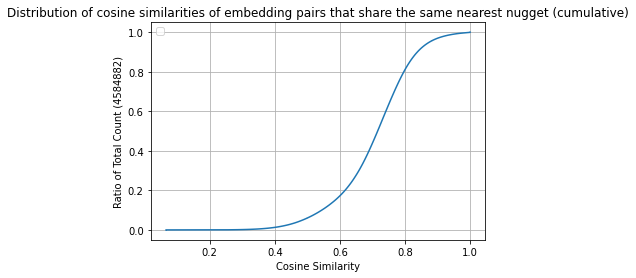

plot saved to /nfs/proj-repo/AAARG-dissertation/tuning_models/mine-trects-kba2014-filtered/stsb-roberta-base/embedding_cos_sim_nearest_nug_1024/same_nearest_nug_distribution.png
df saved as hdf complevel 9 at: /nfs/proj-repo/AAARG-dissertation/tuning_models/nn_path_df.hdf
Redundancy threshold saved as 0.4854188715149244


/usr/local/lib/python3.6/dist-packages/pandas/core/generic.py:2449: PerformanceWarning: 
your performance may suffer as PyTables will pickle object types that it cannot
map directly to c-types [inferred_type->mixed-integer,key->block0_values] [items->Index(['corpus_name', 'nested_dir', 'X_col', 'y_col', 'tuner_dir',
       'tuner_name', 'best_hyperparams', 'batch_size', 'best_model_path',
       'input_param_text_path', 'layer_type'],
      dtype='object')]

  encoding=encoding,


<Figure size 432x288 with 0 Axes>

In [41]:
thresh_gen.generate_threshold(corpus_name, nested_dir, X_col, y_col, batch_size, layer_type,
                          train_topics, k=k, verbose=verbose, force_reload=force_reload, save=save,
                             min_tokens=min_tokens)

In [ ]:
# def get_debug_model():
#     model_path = '/nfs/proj-repo/debug_model'
#     model = tf.keras.models.load_model(model_path)
#     print("loaded model")
#     return model, model_path

# # model_path_handler = ModelPathHandler()
# # print(display(model_path_handler.df))

In [ ]:
# corpus_name = "mine-trects-kba2014-filtered"
# nested_dir = "stsb-roberta-base"
# X_col = "embedding"
# y_col = "cos_sim_nearest_nug"
# batch_size = 1024

# model, debug_tuner_dir = get_debug_model()

# # model = model_path_handler.load_best_model(corpus_name, nested_dir, X_col, y_col, batch_size)
# # tuner_inst_mask = model_path_handler.create_df_mask(corpus_name, nested_dir, X_col, y_col, batch_size)
# # model_df = model_path_handler.df
# # tuner_inst = model_df.loc[tuner_inst_mask]
# # best_hyperparams = list(tuner_inst['best_hyperparams'])[0]
# # print("best_hyperparams")
# # print(best_hyperparams)

# # model_path = "/nfs/proj-repo/AAARG-dissertation/tuning_models/mine-trects-kba2014-filtered/stsb-roberta-base/embedding_cos_sim_nearest_nug_1024/best_models/0"
# # model = tf.keras.models.load_model(model_path)

# print(model.summary())

In [ ]:
# sum_gen = RedundancyThresholdGenerator()

In [ ]:
# test_ids = np.arange(11, 15).tolist()
# test_paths, test_emb_dir = sum_gen.get_emb_paths(corpus_name, nested_dir, test_ids)

In [ ]:
# def show_df_test(emb_paths):
#     for emb_path in tqdm_notebook(emb_paths):
#         emb_df = load_embeddings(emb_path, verbose=False)
#         cosnugs = list(emb_df['cos_sim_nearest_nug'])
#         for cos in cosnugs:
#             if cos > 0:
#                 print("positive")
# #     print(display(emb_df[0:200]))
    
# # show_df_test(test_paths)

In [ ]:
# k = 100000
# batch_size = 256
# save = True
# force_reload = False
# test_top_scores = sum_gen.get_top_train_set_sentence_scores(test_paths, debug_tuner_dir, model, k=k, 
#                                                             batch_size=batch_size,
#                                                  save=save, force_reload=force_reload)

In [ ]:
# sum_gen.get_top_train_set_sentence_scores(test_paths, debug_tuner_dir, model, k=k, 
#                                                             batch_size=batch_size,
#                                                  save=False, force_reload=True)

In [ ]:
# print(display(test_top_scores[(len(test_top_scores) - 300):]))
# print(display(test_top_scores[test_top_scores['sentence'].str.contains("Hostages from at least 10 nations in Algeria")]))

In [ ]:
# emb_dir = "/nfs/proj-repo/AAARG-dissertation/dataset/mine-trects-kba2014-filtered/embeddings/stsb-roberta-base"
# sample_embs = list(test_top_scores['embedding'][(len(test_top_scores) - 1000):])

# # print("sample_embs: " + str(sample_embs))

# same_nug_sims, dif_nug_sims = sum_gen.compare_sim_nuggets(emb_dir, sample_embs)
# print("cell complete")

In [ ]:
sum_gen.plot_sim_nugget_distributions(same_nug_sims, dif_nug_sims)

## Generate Summaries

In [44]:
def gen_score_df_path(tuner_dir, topic_id, X_col, corpus_name):
    fn = str(topic_id) + "_" + str(X_col) + "_" + str(corpus_name)
    fn += ".hdf"
    path = os.path.join(tuner_dir, fn)
    return path

def float_only_decimal_place(num, num_after_dp=3):
    """Transform a float to a string with only selected numbers after decimal place
    
    e.g. 0.23492 (float) -> 23 (str)
    """
    num = str(num)
    num = num.split(".")
    num = num[1]
    num = num[0:num_after_dp]
    return num

def gen_ranked_df_path(tuner_dir, rank_method, topic_id, X_col, corpus_name, min_tokens=None,
                      redundancy_threshold=None):
    fn = str(rank_method)
    if redundancy_threshold is not None:
        # get redundancy threshold (float) as string
        redund_str = float_only_decimal_place(num)
        fn += "_" + str(redund_str)
    if min_tokens is not None:
        fn += "_" + str(min_tokens)
    fn += "_" + str(topic_id) + "_" + str(X_col) + "_" + str(corpus_name)
    fn += ".hdf"
    path = os.path.join(tuner_dir, fn)
    return path

def gen_summary_path_from_ranked_df_path(ranked_df_path):
    # remove .hdf extension
    summary_path = str(ranked_df_path)
    if summary_path[-4] == ".hdf":
        str_path = summary_path[0:len(summary_path) - 4]
        str_path += ".txt"
        return str_path
    else:
        raise Exception("Path does not end in .hdf as expected: " + str(ranked_df_path))

def gen_varname_path(tuner_dir, varname, rank_method, topic_id, X_col, corpus_name):
    fn = "ranked_idxs" + "_" + str(rank_method) + "_" + str(topic_id) + "_" + str(X_col) + str(corpus_name)
    fn += ".pickle"
    path = os.path.join(tuner_dir, fn)
    return path

In [50]:
class SummaryGenerator:
    def __init__(self, model_path_handler, proj_repo='/nfs/proj-repo/AAARG-dissertation'):
        self.model_path_handler = self.model_path_handler
        self.path_ret = PathRetriever(proj_repo)
        self.proj_repo = proj_repo
        self.rank_methods = ['k', 'k_non_redund']
        self.ordering_methods = ["score", "sent_position", None]
        
    def generate_summary(self, corpus_name, nested_dir, X_col, y_col, batch_size, layer_type, test_topic_ids,
                        k=10000, verbose=True, force_reload=False, save=True, remove_emb_df_redundancy=True,
                        rank_method="k_non_redund", min_tokens=3, ordering="sent_position"):
        
        # get model entry on path df
        model_entry = self.model_path_handler.get_tuner_instance(corpus_name, nested_dir, X_col, y_col, 
                                                                 batch_size, layer_type)
        # get tuner dir to save files
        tuner_dir = str(model_entry['tuner_dir'])
        
        # model to make predictions
        model_path = str(model_entry['best_model_path'])
        model = load_model(model_path)
        
        # execute for each topic in test set
        for topic_id in tqdm_notebook(test_topic_ids):
            if topic_id == 7:  # special empty case
                continue
        
            # create a df with a prediction score for each sentence in topic
            score_df = self.generate_topic_score_df(tuner_dir, corpus_name, nested_dir, topic_id, X_col, 
                                                    layer_type,
                                      batch_size=batch_size, verbose=verbose,
                                      force_reload=force_reload, save=save)
            
            # rank sentences by relevancy
            ranked_df, ranked_df_path = self.generate_ranked_df(rank_method, score_df, tuner_dir, corpus_name, 
                                                topic_id, X_col,
                                                k=k, redundancy_score=redundancy_score, 
                                                verbose=verbose, force_reload=force_reload,
                                               min_tokens=min_tokens, save=save)
            
            # generate text summary
            self.create_text_summary(ranked_df, ranked_df_path, ordering=sent_position, 
                                     force_reload=force_reload)
        
        print("Summaries generated")
            
        
    def generate_topic_score_df(self, tuner_dir, corpus_name, nested_dir, topic_id, X_col, layer_type,
                                batch_size=256, verbose=verbose,
                                  force_reload=False, save=True):
        # create/load predicted scores
        score_df_path = gen_score_df_path(tuner_dir, topic_id, X_col, corpus_name)
        score_df = None
        if os.path.exists(score_df_path) and not force_reload:  # load
            score_df = read_df_file_type(score_df_path, verbose=verbose)
        else: # generate new score_df
            # get paths for topic
            emb_paths = self.path_ret.get_embedding_paths(corpus_name, nested_dir, topic_ids=topic_id, 
                                                          return_dir_path=False, verbose=verbose)
            emb_paths = list(emb_paths['path'])
            
            # load model
            model = self.model_path_handler.load_best_model(corpus_name, nested_dir, X_col, y_col, 
                                                            batch_size, layer_type)
            
            # create df of predicted scores
            score_df = self.get_prediction_scores(model, emb_paths, X_col=X_col, batch_size=batch_size,
                                                 sort_scores=True)
            # save df
            if save:
                save_df_file_type(score_df, score_df_path, verbose=verbose)
        return score_df
    
    def get_prediction_scores(self, model, emb_paths, X_col='embedding',
                             batch_size=256, sort_scores=True, add_X_col_to_df=True):
        """
        Differs from RedundancyThresholdGenerator process by assumption all emb_dfs can be loaded into memory
        
        Return dataframe with columns:
            sentence: string of sentence
            score: predicted score from model
            relative_pos: relative_position of sentence in its article (sent_id)
            streamid: streamid of article sentence is from
            embedding (optional): embedding of sentence (determined by X_col parameter)
        """
        
        # predict scores for target embeddings to place into df
        score_df_dict = defaultdict(list)
        print("Predicting scores...")
        for emb_path in tqdm_notebook(emb_paths):
            # load emb_df
            emb_df = load_embeddings(emb_path, verbose=False)
            embs = list(embs[X_col])
            
            # predict scores
            scores = predict_emb_list(model, emb_list, batch_size=batch_size)
            
            score_df_dict['sentence'].extend(list(emb_df['sentence']))
            score_df_dict['score'].extend(scores.tolist())
            score_df_dict['relative_pos'].extend(list(emb_df['sent_id']))  # relative position in article
            score_df_dict['streamid'].extend(list(emb_df['streamid']))
            if add_X_col_to_df:
                score_df_dict['embedding'].extend(embs)
        
        # tie sentence <-> score together and access DataFrame functionality
        score_df = pd.DataFrame(score_df_dict)
        if sort_scores:
            score_df = score_df.sort_values(by="score", ascending=False)  # descending order
        return score_df
        
    def generate_ranked_df(self, rank_method, score_df, tuner_dir, corpus_name, topic_id, X_col, k=10000,
                           redundancy_score=None, verbose=verbose, force_reload=False,
                          min_tokens=None, save=True):
        
        # get ranked df path
        ranked_df_path = None
        if rank_method == "k":
                ranked_df_path = gen_ranked_df_path(tuner_dir, rank_method, topic_id, X_col, corpus_name)
        elif rank_method == "k_non_redund":
            ranked_df_path = gen_ranked_df_path(tuner_dir, rank_method, topic_id, X_col, corpus_name, 
                                        min_tokens=min_tokens, redundancy_threshold=redundancy_threshold)
        
        # determine if load ranked_df or create new one
        ranked_df = None
        if not os.path.exists(ranked_df_path) or force_reload:
            # load new ranked_df with selected method
            ranked_idxs = None
            ranked_df_path = None
            if rank_method == "k":
                ranked_df = self.retrieve_top_k_sentences(score_df, k, is_sorted=True)
            elif rank_method == "k_non_redund":
                ranked_df, ranked_idxs = self.ret_top_k_non_redundant(score_df, 
                                                                    k, 
                                                                    redundancy_threshold, 
                                                                    X_col='embedding', 
                                                                    is_sorted=True,
                                                                    return_indexes=True,
                                                                    min_tokens=min_tokens)
            else:
                raise Exception(str(rank_method) + " is not a valid rank_method: " + str(self.rank_methods))
                
            
            # save ranked_idxs
            if ranked_idxs is not None:
                ranked_idxs_path = gen_varname_path(tuner_dir, "ranked_idxs", rank_method, topic_id, X_col,
                                                   corpus_name)
                with open(ranked_idxs_path, 'wb') as handle:
                    pickle.dump(ranked_idxs, handle, protocol=pickle.HIGHEST_PROTOCOL)
                    
            # save ranked_df
            if save:
                save_df_file_type(ranked_df, ranked_df_path, verbose=verbose)
        else:
            ranked_df = read_df_file_type(ranked_df_path, verbose=verbose)
            
        return ranked_df, ranked_df_path  # return path to create path for summary
        
    def retrieve_top_k_sentences(self, score_df, k, is_sorted=True):
        """
        Retrieve top k scoring sentences from score_df
        """
        if not is_sorted:
            score_df = score_df.sort_values(by="score", ascending=False)
        
        top_k_df = score_df[0:k]
        
        return top_k_df
    
    def ret_top_k_non_redundant(self, score_df, k, redundancy_threshold, X_col='embedding', is_sorted=True,
                               return_indexes=True, min_tokens=None):
        """
        Retrieve top k sentences from df, not repeating redundant sentences
        """
        if not is_sorted:
            score_df = score_df.sort_values(by="score", ascending=False)
        
#         score_df_copy = copy.deepcopy(score_df)
        
        top_k_rows = []
        top_k_row_idxs = None
        if return_indexes:  # for statistics
            top_k_row_idxs = []
            
        nlp = None  # for min tokens
        if min_tokens is not None:
            nlp = spacy.load("en_core_web_sm")
        
        # iteratively find top k sentences where cosine similarity is under redundancy_threshold
        for index, row in tqdm_notebook(score_df.iterrows()):
            # check if sentence meets minimum tokens
            if min_tokens is not None:
                num_tokens = len(nlp(str(row['embedding'])))
                if num_tokens < min_tokens:
                    continue
            
            # for each sentence, compare cosine similarity with existing chosen sentences
            under_threshold = True
            row_emb = row['embedding']
            for k_row in top_k_rows:
                
                k_emb = k_row['embedding']
                cos_sim = cosine_similarity(row_emb, k_emb)
                
                # if sentence is above allowed level of similarity with other sentences
                if cos_sim > redundancy_threshold:  
                    under_threshold = False
                    break  # break from nested loop
            
            # add sentence that is above allowed level of similarity
            if under_threshold: 
                top_k_rows.append(row)
                if return_indexes:  # for statistics
                    top_k_row_idxs.append(index)
            
            # end when we have collected k sentences
            if len(top_k_rows) == k:
                break
        
        top_k_df = pd.DataFrame(top_k_rows)
#         top_k_df = self.order_by_article_position(top_k_df)
        return top_k_df

    def create_text_summary(self, ranked_df, ranked_df_path, ordering=None, force_reload=False):
        # order by select ordering
        if ordering == "score":
            ranked_df = ranked_df.sort_values(by="score", ascending=False)
        elif ordering == "sent_position":
            ranked_df = self.order_by_sent_position(ranked_df)
        else:
            if ordering not in self.ordering_methods:
                raise Exception("Invalid ordering parameter")
        
        # get path to save to
        summary_path = gen_summary_path_from_ranked_df_path(ranked_df_path)
        if not os.path.exists(summary_path) or force_reload:
            # get sents (previously ordered)
            sents = ranked_df['sentence']
            # write to text file
            with open(summary_path, "w") as f:
                for sent in sents:
                    out = str(sent) + " "  # add spacing between sentences
                    f.write(out)
        print("Text summary saved to: " + str(summary_path))
    
    def order_by_sent_position(self, ranked_df):
        """Order sentences by relative article position"""
        ranked_df = ranked_df.sort_values(by="relative_pos", ascending=True)
        return ranked_df